# Predicting Flight Delay

Problem Set-up:
We define a delayed flight to be one that is delayed by >= 15 minutes. 
The prediction problem is to train a model that can classify flights, to predict if they will or will not be delayed.

Use case:
- The idea is that this model would be useful to choosing airlines, flightpaths, airports, at the time of booking, relatively in advance of the scheduled departure (days, weeks, months ahead of time). Therefore, the prediction problem will focus on features that can be known in advance, rather than predicting using day-off features like weather and previous flights from that day. 

Notes:
- We restrict the analysis to relatively large airport, those with more than 20 (domestic) flights a day

# This notebook: more features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

# Create separate models to predict for each airport 

Motivation:
The weights that should eb put on features (e.g. airlines) may differ depending on the airport (see e.g. NB 4B) since different airports can have different environments (e.g. San Diego and Chicago winters are very different; American Airlines is better in Tuscon than in Anchorage.

In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression

In [2]:
# Import custom code
from flightdelay.fld import io as flio

# Load data

In [3]:
airlines_df, airports_df, flights_df = flio.load_data()

In [4]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [5]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [6]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [7]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

# Remove cancelled flights

In [8]:
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


# Make train and val set

In [9]:
N_flights = 1000000
N_train = int(N_flights*.7)
np.random.seed(0)
flight_take_idx = np.random.permutation(flights_df.index)[:N_flights]
df_trainval = flights_df.loc[flight_take_idx]

In [10]:
df_trainval.head(20)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
3783504,8,23,7,WN,285,N7738A,MCI,DEN,1410,1408.0,...,1414.0,105.0,95.0,83.0,533,1437.0,6.0,1455,1443.0,-12.0
5412589,12,5,6,AS,335,N520AS,SJC,SEA,1550,1534.0,...,1554.0,120.0,135.0,105.0,697,1739.0,10.0,1750,1749.0,-1.0
5347613,12,1,2,UA,1750,N76254,SAN,IAH,1314,1354.0,...,1406.0,188.0,168.0,148.0,1303,1834.0,8.0,1822,1842.0,20.0
2383329,5,31,7,WN,396,N8318F,AUS,DEN,1935,2039.0,...,2051.0,140.0,128.0,109.0,775,2140.0,7.0,2055,2147.0,52.0
2817074,6,26,5,EV,4899,N133EV,ATL,MYR,1454,1509.0,...,1533.0,85.0,77.0,49.0,317,1622.0,4.0,1619,1626.0,7.0
5428910,12,6,7,OO,5236,N756SK,ORD,OKC,1913,1925.0,...,1949.0,133.0,121.0,91.0,693,2120.0,6.0,2126,2126.0,0.0
4073892,9,10,4,HA,516,N484HA,HNL,OGG,2150,2144.0,...,2155.0,38.0,41.0,23.0,100,2218.0,7.0,2228,2225.0,-3.0
2296450,5,26,2,EV,6176,N12996,EWR,GSO,1306,1318.0,...,1330.0,99.0,85.0,68.0,445,1438.0,5.0,1445,1443.0,-2.0
1182922,3,18,3,WN,1969,N932WN,TPA,MDW,1330,1330.0,...,1344.0,160.0,159.0,141.0,997,1505.0,4.0,1510,1509.0,-1.0
5228455,11,23,1,WN,2375,N8323C,IND,TPA,1545,1546.0,...,1555.0,135.0,119.0,105.0,837,1740.0,5.0,1800,1745.0,-15.0


# Randomly take subset of data

# Compute features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

### 0. Original feat

In [11]:
original_feat = {'f_distance':df_trainval['DISTANCE'].values}

In [12]:
y_delay = df_trainval['DEPARTURE_DELAY'].values

### 1. Day of week

In [13]:
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [14]:
daysfeat_dict = make_onehot_feat_dict(df_trainval, 'DAY_OF_WEEK', 'day')

### 2. Month

In [15]:
monthsfeat_dict = make_onehot_feat_dict(df_trainval, 'MONTH', 'month') 

### 3. Departing airport

In [16]:
dapfeat_dict = make_onehot_feat_dict(df_trainval, 'ORIGIN_AIRPORT', 'dap') 

### 4. Airline

In [17]:
alfeat_dict = make_onehot_feat_dict(df_trainval, 'AIRLINE', 'al') 

### 5. Departure hour

In [18]:
# Add departure hour as a feature
df_trainval['HOUR_DEPARTURE'] = np.floor(df_trainval['SCHEDULED_DEPARTURE'].values/100).astype(int)
df_trainval['HOUR_ARRIVAL'] = np.floor(df_trainval['SCHEDULED_ARRIVAL'].values/100).astype(int)
hrfeat_dict = make_onehot_feat_dict(df_trainval, 'HOUR_DEPARTURE', 'hr')

# Save new feature matrix

In [19]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, dapfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [20]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Prepare for training linear model

In [21]:
# zscore all features
from scipy.stats import zscore
df_feat = df_feat.apply(zscore)

In [22]:
# Declare DFs
X_train = df_feat.loc[:N_train-1].values
X_val = df_feat.loc[N_train:].values

In [23]:
# Determine labels
y_delay01 = y_delay > 30
y_train = y_delay01[:N_train]
y_val = y_delay01[N_train:]

# Separate data for each airport

# Train one model

In [24]:
C = 100
model = LogisticRegression(C=C)
#model = LogisticRegression(C=C,fit_intercept=False)
#model = LogisticRegression(C=C,class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Evaluate model

In [25]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_val)
print(model.score(X_train, y_train))
print(sum(model.predict(X_train)))
print(model.score(X_val, y_val))
print(sum(model.predict(X_val)))

0.888301428571
0
0.88766
0


In [26]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_train, preds_train)
print(cmat)

[[621811      0]
 [ 78189      0]]


In [27]:
print('True negative rate:', cmat[1,1]/sum(cmat[1]))
print('True positive rate:', cmat[0,0]/sum(cmat[0]))

True negative rate: 0.0
True positive rate: 1.0


0.671814588027
0.670086148529


(0, 1)

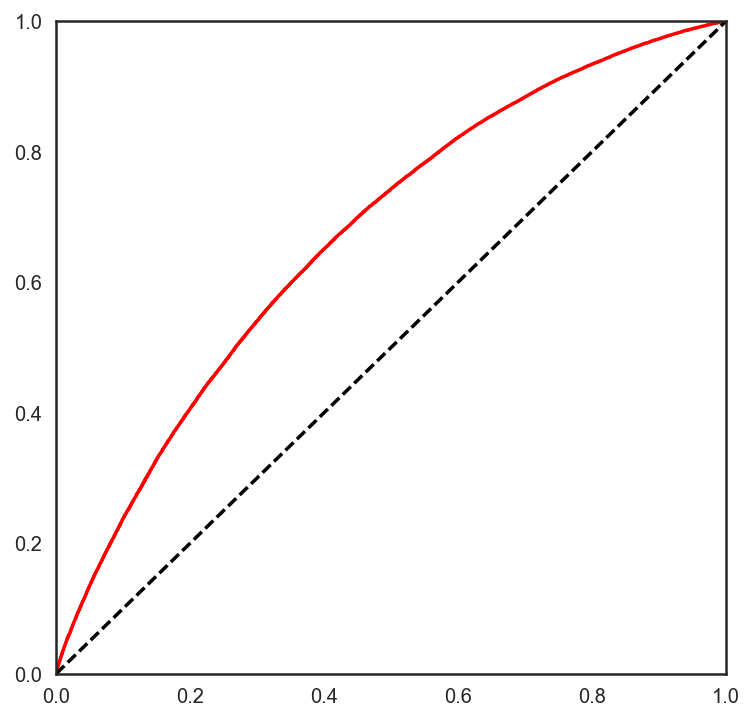

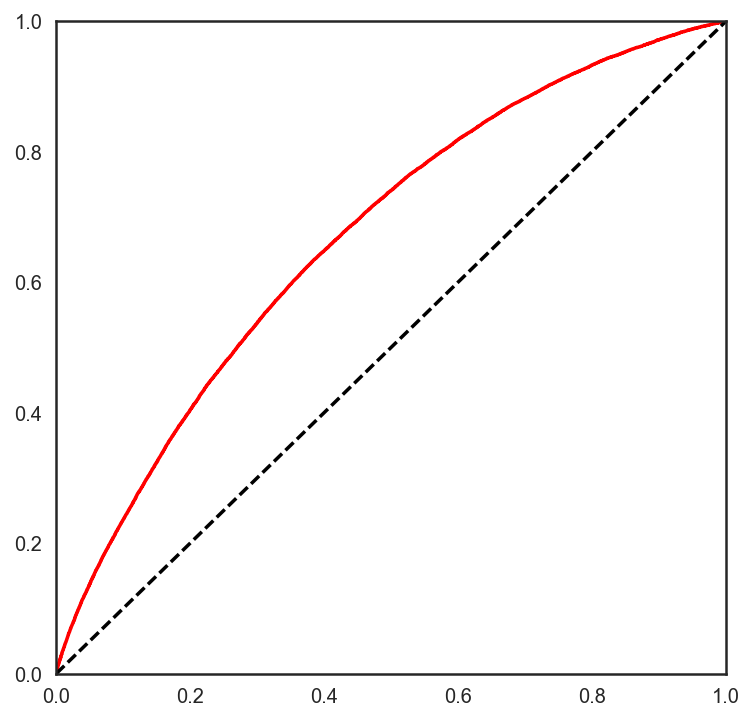

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(y_train, model.predict_proba(X_train)[:,1])
print(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

fpr, tpr, th = roc_curve(y_val, model.predict_proba(X_val)[:,1])
print(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))